<img style="width:100%; height:70%;" src="https://www.newshub.co.nz/dam/form-uploaded-images-ordered/2021/04/11/heavy-rain-storm-clouds-warning-CREDIT-GETTY-520773327-1120.jpg" />

<img style="width:90px; height:90px; float:left;" src="https://acegif.com/wp-content/gifs/globe-17.gif"><img style="width:90px; height:90px; float:right;" src="https://acegif.com/wp-content/gifs/globe-17.gif"><h1 style="color:white; background-color:black; text-align:center;"><b> Weather </b> <i> Forecasting </i><b> using </b><i> RNN </i></h1>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

##we use step 

df = pd.read_csv("../input/jena-climate-2009-2016/jena_climate_2009_2016.csv")
print(df.shape)
df.head()

(420551, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


<img style="width:90px; height:90px; float:left;" src="https://static.wixstatic.com/media/b008fb_8f7ff58ce8444721a4292503c9d2e054~mv2.gif"><img style="width:90px; height:90px; float:right;" src="https://static.wixstatic.com/media/b008fb_8f7ff58ce8444721a4292503c9d2e054~mv2.gif"><h2 style="color:white; background-color:black; text-align:center;"><b><i> Data-Visualization </i></b></h2>

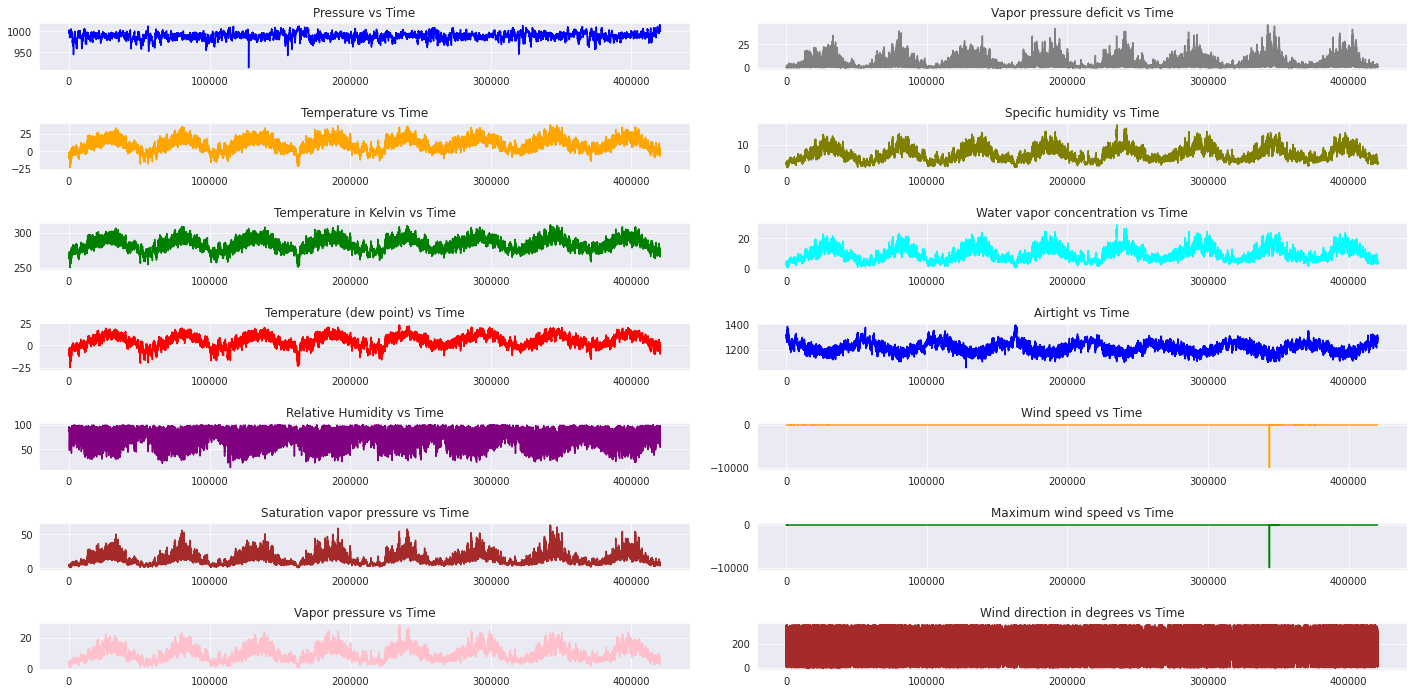

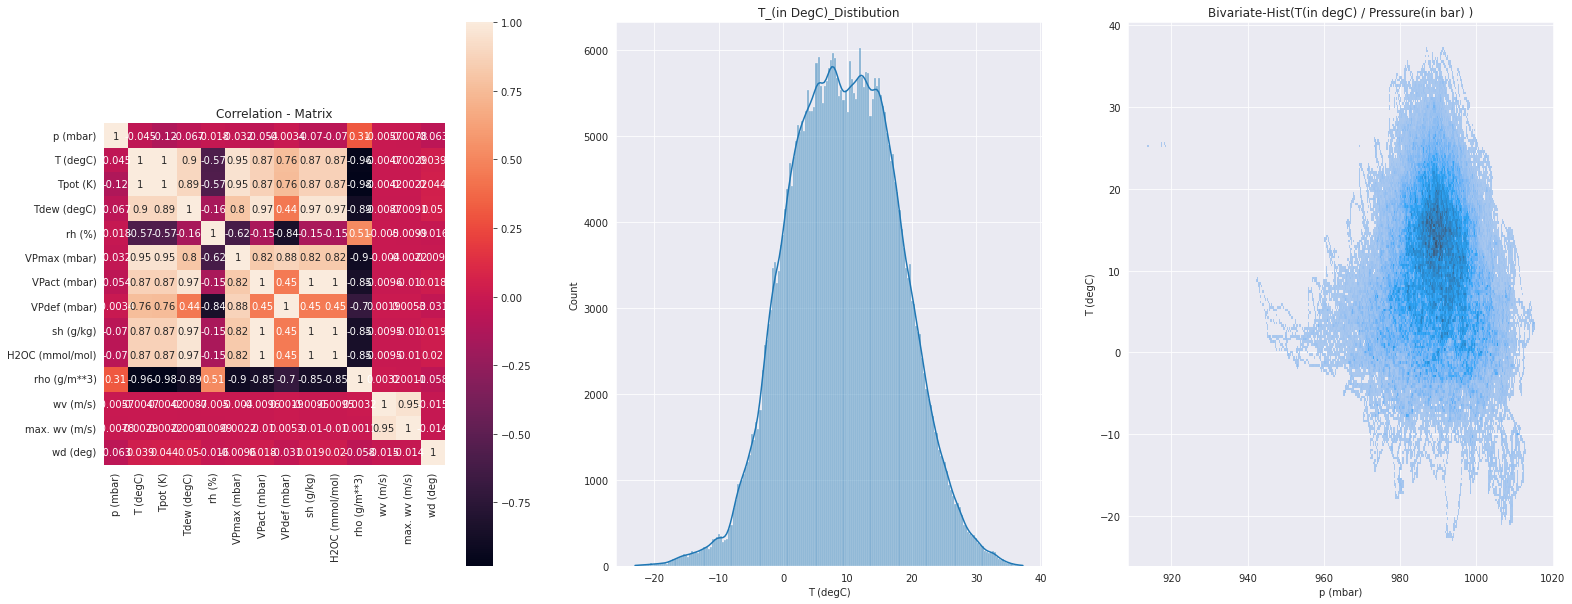

In [2]:
all_cols = df.columns
sns.set_style('darkgrid')
fig, axs = plt.subplots(7,2 , figsize=(20,10))

titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
    "blue",
    "orange",
    "green",
    "brown",
]

for i in range(len(titles)):
    
    if i<= 6:
        axs[i,0].set_title(f'{titles[i]} vs Time');
        axs[i,0].plot(range(len(df[all_cols[0]])), df[all_cols[i+1]],c = colors[i]);
    if i > 6:
        axs[i-7,1].set_title(f'{titles[i]} vs Time');
        axs[i-7,1].plot(range(len(df[all_cols[0]])), df[all_cols[i+1]],c = colors[i]);
        

plt.tight_layout(pad=2)
plt.show()

fig, ax = plt.subplots(1,3, figsize = (26,10))
df_corr = df.corr()
ax[0].set_title('Correlation - Matrix')
sns.heatmap(df_corr, square=True, annot=True, ax=ax[0]);

ax[1].set_title('T_(in DegC)_Distibution')
sns.histplot(df[all_cols[2]], ax = ax[1], kde =True);

ax[2].set_title('Bivariate-Hist(T(in degC) / Pressure(in bar) )')
sns.histplot(
    df, x=all_cols[1], y=all_cols[2],
    discrete=(False, False), log_scale=(False, False), ax= ax[2]
);

plt.show()


<img style="width:120px; height:90px; float:left;" src="http://ibaseelectrosoft.com/iBaseTech/images/training/mlgf.gif"><img style="width:120px; height:90px; float:right;" src="http://ibaseelectrosoft.com/iBaseTech/images/training/mlgf.gif"><h2 style="color:white; background-color:black; text-align:center;"><b><i> Model - Creation </i></b></h2>

In [3]:
df_train = df[['p (mbar)','T (degC)', 'VPmax (mbar)', 'VPdef (mbar)', 'sh (g/kg)' ,'rho (g/m**3)',	'wv (m/s)']] ##Selected Features

data = df_train.to_numpy()
print(data.shape)


def norm(data):
    mean = data[:200000].mean(axis=0)
    data -= mean
    std = data[:200000].std(axis=0)
    data /= std
    
    return data

data = norm(data)
print(data.shape)
    
def gen(data, past, delay, minn, maxx, shuffle=False, batch_size=128, rate=6):
    if maxx is None:
        maxx = len(data) - delay -1
    i = minn + past
    while True:
        if shuffle:
            rows = np.random.randint(minn + past, maxx, size = batch_size)
        else:
            if i + batch_size > maxx:
                i = minn + past
            rows=np.arange(i, min(i + batch_size, maxx))
            i+=len(rows)
            
        samples = np.zeros((len(rows), past // rate, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - past, rows[j], rate) ## sample apoint every hour intead of every 10 mins
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

(420551, 7)
(420551, 7)


In [4]:
past = 720 ## ==>> looks 5 days back 
rate = 6 ## ==>> sample 1 point every hour
delay = 144 ## ==>> predict after 1 day/24 hrs

train_split, test_split = 0.60, 0.25
train_max = round(train_split * data.shape[0])
val_max = (1-train_split)*data.shape[0]
test_max = round(test_split*val_max)
val_max = round(val_max - test_max)

val_steps =  (train_max+val_max) - (train_max+1) - past ## (-past) because no target values for last  720 points
test_steps = (train_max+val_max+test_max)-(train_max+val_max+1) - past

print('Train_Max: ',round(train_max),', Val_Max: ',round(val_max),', Test_Max: ',round(test_max))

train_gen = gen(data, past,delay, minn = 0, maxx = train_max, batch_size=128, shuffle=True)
val_gen = gen(data, past, delay, minn = train_max+1, maxx = train_max + val_max, batch_size=128)
test_gen = gen(data, past, delay, minn = train_max+val_max+1, maxx = train_max+val_max+test_max, batch_size=128)




Train_Max:  252331 , Val_Max:  126165 , Test_Max:  42055


In [5]:
def baseline(val_gen):
    maes = []
    for step, exe in enumerate(val_gen):
        samples, targets = exe
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds-targets))
        maes.append(mae)
        if step == 2000:
            break
    return np.mean(maes)

def visual_loss(hist, base_mae):
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]
    epochs = range(len(loss))
    sns.set_style('darkgrid')
    plt.figure()
    plt.plot(epochs, loss, "1-b", label="Training loss")
    plt.plot(epochs, val_loss, "1-r", label="Validation loss")
    plt.plot(epochs, base_mae*np.ones(len(loss)), 'k-', label = "CommonSense_Baseline_loss")
    plt.title('Loss_Curve')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



In [11]:
#'''
inp = tf.keras.layers.Input(shape = (past // rate, data.shape[-1]))
gru_1 = tf.keras.layers.GRU(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.3)(inp)
gru_2 = tf.keras.layers.GRU(64, activation='relu',dropout=0.1, recurrent_dropout=0.3)(gru_1)

dense = tf.keras.layers.Dense(1, activation='linear')(gru_2)
model = tf.keras.models.Model(inputs = inp, outputs = dense)

model.compile(loss="mae", optimizer="Adam")
model.summary()

se = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5)
hist = model.fit_generator(train_gen, steps_per_epoch=500, epochs=5, validation_data = val_gen, validation_steps= val_steps, callbacks=[se]) ## steps_per_epoch =
#'''                                                                                                          ## number of batches passed during each epoch
base_mae = baseline(val_gen)
print('CommonSense_Baseline_MAE_normalized: ', base_mae)
print('CommonSense_Absoulte_MAE_(in degC)_baseline: ', base_mae*df[all_cols[2]].std(axis=0))
#visual_loss(hist, base_mae)
print()
print('--'*50)
print()
x_t, y_t = next(test_gen)
print(model.evaluate(x_t, y_t))
print('-')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 120, 32)           3936      
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                18816     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 22,817
Trainable params: 22,817
Non-trainable params: 0
_________________________________________________________________
CommonSense_Baseline_MAE_normalized:  0.3106154592753293
CommonSense_Absoulte_MAE_(in degC)_baseline:  2.616427453467909

----------------------------------------------------------------------------------------------------

4/4 [========================

<img style="width:100px; height:90px; float:left;" src="https://thumbs.gfycat.com/GoldenPleasantAmericancreamdraft-max-1mb.gif"><img style="width:100px; height:90px; float:right;" src="https://thumbs.gfycat.com/GoldenPleasantAmericancreamdraft-max-1mb.gif"><h2 style="color:white; background-color:black; text-align:center;"><b><i> Inference </i></b></h2>

x-test:  (128, 120, 7) yreal:  (128,)


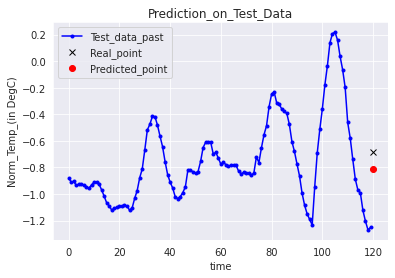

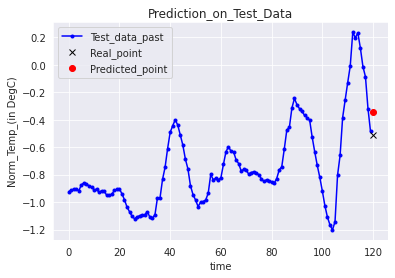

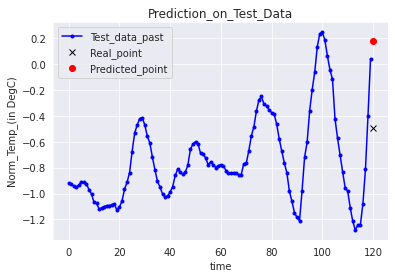

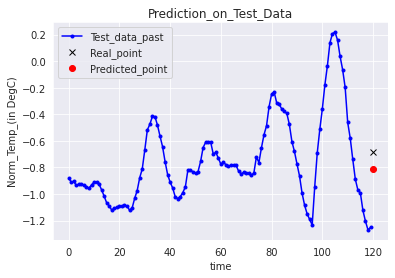

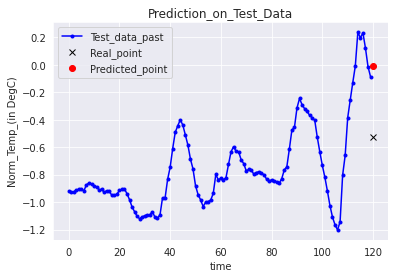

In [9]:
import random
def predict(seed, x_test, yreal):
    c = seed
    kx = x_test[c,:,1].tolist() ## every 120/seq_length time-steps / point is going to have a single future point (here T in C on of the the given features)
    pred = model.predict(x_test)
    ky = yreal[c]
    x_lin = range(len(kx))
    plt.plot(x_lin, kx, '.-b', label = 'Test_data_past' )
    plt.plot(x_lin[-1]+1, ky, 'kx', label = 'Real_point')
    plt.plot(x_lin[-1]+1, pred[c], 'ro', label ='Predicted_point' )
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('Norm_Temp_(in DegC)')
    plt.title('Prediction_on_Test_Data')
    plt.show()

batch_size =128
seed = 10
num = 5

x_test, yreal = next(test_gen)
print('x-test: ', x_test.shape, 'yreal: ', yreal.shape)

for _ in range(num):
    seed = random.randint(0, batch_size-2)
    predict(seed, x_test, yreal)